In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from UsefulFunctions import *
import seaborn as sns
from config_path import MS_DATA_PATH, SEPSIS_PATH, HA_PATH
from dpks.quant_matrix import QuantMatrix
import csv


Base path: ..


In [2]:
def get_proteins_triv_name(proteins):
    human_proteome = pd.read_csv('../data/human_proteome.gz')
    human_proteome['accession'] = human_proteome['accession'].apply(lambda x: x.split('_')[0])
    names = []
    for protein in proteins:
        if protein in human_proteome['accession'].values:
            m = human_proteome.loc[human_proteome['accession'] == protein]['trivname'].values
            assert len(m) == 1
            m = m[0].split('_')[0]
        else:
            m = protein
        names.append(m)
    return names

## DPKS
---

In [3]:
import pyperclip
covid = pd.read_csv('../data/ms/covid/AaronQM.tsv', sep="\t")
s = ""
for r in covid['Protein'].values:
    s = s+r+ "\n"
pyperclip.copy(s)


In [4]:
qm_covid= QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/covid/Aaron_data_cropped.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/covid/design_cropped.tsv"
)
qm_covid = qm_covid.normalize(method="mean").quantify(method='maxlfq', threads=12)


In [5]:
compare_df_covid = qm_covid.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df().dropna(subset=['CorrectedPValue'])

compare_df_covid['logPValue'] = compare_df_covid['PValues1-2'].apply(lambda x: -np.log(x))
compare_df_covid['DifferentialExpression'] = ((compare_df_covid['logPValue']/max(compare_df_covid['logPValue'].values))**2 
                                        + (compare_df_covid['Log2FoldChange1-2']/max(compare_df_covid['Log2FoldChange1-2'].values))**2)**0.5
compare_df_covid['trivname'] = get_proteins_triv_name(compare_df_covid['Protein'])
proteins = compare_df_covid.sort_values('DifferentialExpression', ascending=False)['trivname'][0:20]
proteins.values

array(['CRP', 'PIGR', 'SAA2', 'SAA1', 'CXCL7', 'LBP', 'PEDF', 'CYTC',
       'ITIH4', 'ZA2G', 'A2GL', 'AMBP', 'HEMO', 'TSP1', 'GELS', 'APOE',
       'CO9', 'LV301', 'S10A8', 'PCOC1'], dtype=object)

   color  count
0  black    165
1   blue      3
2    red      1
Group 1: 125.38790035587189 +- 11.803359022057839 Group 2: 126.15270935960591 +- 10.537352283756169


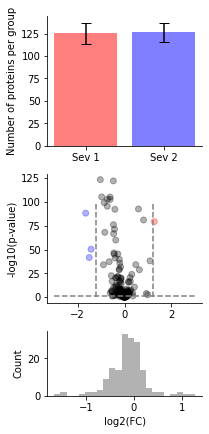

In [6]:

GroupOneCols = qm_covid.get_samples(1)
GroupTwoCols = qm_covid.get_samples(2)
compare_df_covid['logPValue'] = compare_df_covid['PValues1-2'].apply(lambda x: -np.log(x))
compare_df_covid['color'] = compare_df_covid.apply(lambda x: color_if_significant(x), axis=1)
compare_df_covid['count'] = 1
print(compare_df_covid.groupby('color', as_index=False).sum()[['color','count']])

fig, ax = plt.subplots(3,1,sharex=False, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df_covid[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df_covid[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")


ax[1].scatter(x=compare_df_covid['Log2FoldChange1-2'].values , y=compare_df_covid['logPValue'].values, color=compare_df_covid['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=100, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=100,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-3, xmax=3, color='gray', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df_covid['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')
ax[2].set_xlabel('log2(FC)')



ax[0].bar(x = ['Sev 1', 'Sev 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of proteins per group')

plt.tight_layout()

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

#plt.savefig('../plots/manuscript/covid_ProteinVolcanoHist.svg', bbox_inches='tight', dpi=300)

In [7]:
qm_sepsis= QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/sepsis/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/sepsis/inner_design_matrix.tsv"
)
qm_sepsis = qm_sepsis.normalize(method="mean").quantify(method='maxlfq', threads=12)



In [8]:
compare_df_sepsis = qm_sepsis.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df()

compare_df_sepsis['logPValue'] = compare_df_sepsis['PValues1-2'].apply(lambda x: -np.log(x))
compare_df_sepsis['DifferentialExpression'] = ((compare_df_sepsis['logPValue']/max(compare_df_sepsis['logPValue'].values))**2 
                                        + (compare_df_sepsis['Log2FoldChange1-2']/max(compare_df_sepsis['Log2FoldChange1-2'].values))**2)**0.5
compare_df_sepsis['trivname'] = get_proteins_triv_name(compare_df_sepsis['Protein'])
proteins = compare_df_sepsis.sort_values('DifferentialExpression', ascending=False)['trivname'][0:20]
proteins

232     DEF1
78     ICAM1
148     CD14
163     B2MG
153     CD44
273     PYGL
139    C163A
536    FCG3A
114     PEDF
397    LYAM1
465     PSA5
191    B4GT1
183     C1RL
462     NGAL
527     GFAP
209     IBP4
261     G6PI
214     PSB6
223    VCAM1
24      CYTC
Name: trivname, dtype: object

   color  count
0  black    485
1   blue     50
2    red     19
Group 1: 330.0945945945946 +- 30.87514915990621 Group 2: 360.2845528455285 +- 38.34238570920208


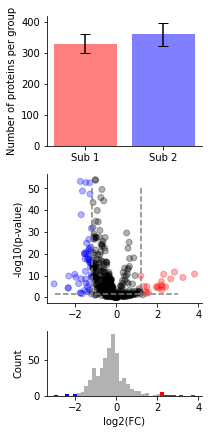

In [9]:

GroupOneCols = qm_sepsis.get_samples(1)
GroupTwoCols = qm_sepsis.get_samples(2)
compare_df_sepsis['logPValue'] = compare_df_sepsis['PValues1-2'].apply(lambda x: -np.log(x))
compare_df_sepsis['color'] = compare_df_sepsis.apply(lambda x: color_if_significant(x), axis=1)
compare_df_sepsis['count'] = 1
print(compare_df_sepsis.groupby('color', as_index=False).sum()[['color','count']])

fig, ax = plt.subplots(3,1,sharex=False, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df_sepsis[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df_sepsis[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")


ax[1].scatter(x=compare_df_sepsis['Log2FoldChange1-2'].values , y=compare_df_sepsis['logPValue'].values, color=compare_df_sepsis['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=50, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=50,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-3, xmax=3, color='gray', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df_sepsis['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')
ax[2].set_xlabel('log2(FC)')



ax[0].bar(x = ['Sub 1', 'Sub 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of proteins per group')

plt.tight_layout()

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

#plt.savefig('../plots/manuscript/sepsis_ProteinVolcanoHist.svg', bbox_inches='tight', dpi=300)

In [13]:
data = "aaron"
filepath = f'../plots/manuscript/network/{data}_processed.csv'
shap = pd.read_csv(filepath)
shap = shap[shap['source layer'] == 0].groupby('source', as_index=False).mean()
if data == "aaron":
    compare_df = compare_df_covid
else:
    compare_df = compare_df_sepsis
compare_df = compare_df.merge(shap, left_on="trivname", right_on="source", how='left')
compare_df = compare_df.dropna(subset=['value'])
compare_df

,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_P1911_190,TM_P1911_191,...,source layer,target layer,normalized value,unique,fan_in,fan_out,fan_tot,nodes_in_SG,log(Nodes in SG),weighted_val_log
0,P08603,22.704976,22.778449,-0.073473,0.167402,74,123,0.134529,22.491483,22.858132,...,0.0,1.0,0.000910,1.0,0.0,1.0,1.0,6.0,2.584963,0.000464
1,P02671,24.711628,24.731697,-0.020069,0.841549,74,123,0.442396,25.191728,25.320787,...,0.0,1.0,0.009616,1.0,0.0,21.0,21.0,44.0,5.459432,0.002718
2,P01042,22.455992,22.555733,-0.099741,0.092295,74,123,0.081025,21.898323,21.943888,...,0.0,1.0,0.024467,1.0,0.0,7.0,7.0,19.0,4.247928,0.008512
3,P00450,22.848118,23.019525,-0.171407,0.006293,74,123,0.007971,22.833492,23.386586,...,0.0,1.0,0.002704,1.0,0.0,5.0,5.0,15.0,3.906891,0.001006
4,P05156,21.192046,21.294379,-0.102333,0.220999,74,123,0.165594,21.056419,21.366153,...,0.0,1.0,0.000078,1.0,0.0,1.0,1.0,6.0,2.584963,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,18.769939,19.788901,-1.018962,0.000123,12,54,0.000234,NaN,NaN,...,0.0,1.0,0.001262,1.0,0.0,2.0,2.0,10.0,3.321928,0.000533
550,Q06323,19.514362,18.022822,1.491540,0.161708,2,5,0.130742,NaN,NaN,...,0.0,1.0,0.002681,1.0,0.0,46.0,46.0,111.0,6.794416,0.000628
551,P16035,18.542429,18.466542,0.075887,0.759335,14,30,0.404306,NaN,19.124122,...,0.0,1.0,0.001377,1.0,0.0,2.0,2.0,8.0,3.000000,0.000629
552,O95633,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,...,0.0,1.0,0.000166,1.0,0.0,3.0,3.0,10.0,3.321928,0.000070


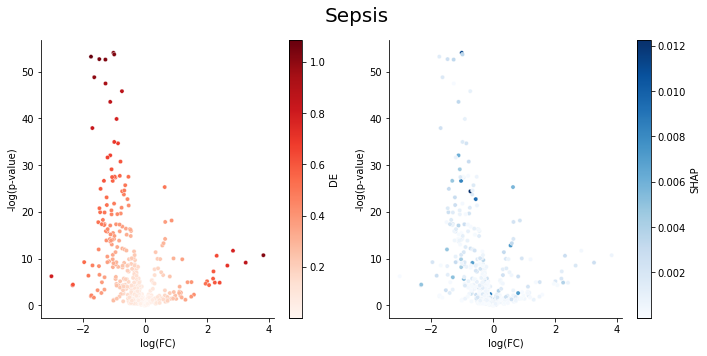

In [15]:
fig, axs= plt.subplots(1,2, figsize=(10,5))

ax1 = sns.scatterplot(x="Log2FoldChange1-2", y="logPValue", hue="DifferentialExpression",
                     palette='Reds', data=compare_df, ax  = axs[0], size=1)
ax2 = sns.scatterplot(x="Log2FoldChange1-2", y="logPValue", hue="weighted_val_log",
                     palette='Blues', data=compare_df, ax  = axs[1], size=1)

norm = plt.Normalize(compare_df['DifferentialExpression'].min(), compare_df['DifferentialExpression'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
plt.colorbar(sm, ax=axs[0], label="DE")

norm = plt.Normalize(compare_df['weighted_val_log'].min(), compare_df['weighted_val_log'].max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
plt.colorbar(sm, ax=axs[1], label="SHAP")

ax1.get_legend().remove()
ax2.get_legend().remove()
for ax in axs.ravel():
    ax.set_xlabel('log(FC)')
    ax.set_ylabel('-log(p-value)')
sns.despine()
plt.suptitle('Sepsis', fontsize=20)
plt.tight_layout()

plt.savefig(f'../plots/manuscript/{data}_volcano_DE_SHAP_weighted.svg', dpi=300, bbox_inches="tight")

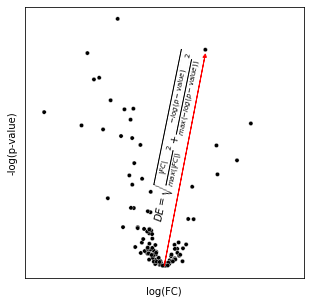

In [190]:
plt.figure(figsize=(5,5))
ax1 = sns.scatterplot(x="Log2FoldChange1-2", y="logPValue", 
                     color='black', data=compare_df_covid,size=1)
ax1.get_legend().remove()
plt.xlabel('log(FC)')
plt.ylabel('-log(p-value)')
plt.xlim(-2,2)
plt.xticks([])
plt.yticks([])
plt.arrow(0,0, .58, 123, color='r',  head_width=0.05, head_length=2)
plt.text(-0.27, 28, r" $DE = \sqrt{ \frac{|FC|}{max(|FC|)}  ^2 + \frac{-log(p-value)}{max(-log(p-value))} ^2}$", color="k", fontsize=10, rotation=78.5)
plt.savefig('../plots/manuscript/volcano_example.eps', dpi=300, bbox_inches="tight")